<a href="https://colab.research.google.com/github/Rahisha-rp/-eeg_motor_movement_imagery_dataset/blob/main/Credit_Risk_Modeling_with_Python1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Loading the dataset...
Error: The file 'accepted_2007_to_2018Q4.csv.gz' was not found. Please ensure it is in the correct directory.
Creating a small placeholder DataFrame for demonstration.

Initial data shape: (100, 5)

First 5 rows of the dataset:
   loan_amnt      term     grade  annual_inc  loan_status
0   0.797701  0.288983  0.428117    0.118011      Current
1   0.128861  0.357966  0.844076    0.043376      Current
2   0.229135  0.343704  0.037951    0.612620  Charged Off
3   0.030228  0.582418  0.949701    0.734431      Current
4   0.735154  0.984987  0.077840    0.572581      Current

Summary of missing values:
loan_amnt      0
term           0
grade          0
annual_inc     0
loan_status    0
dtype: int64

Step 2: Cleaning and preprocessing the data...

Filtered data shape after selecting target statuses: (64, 5)

Dropped 0 columns due to high missing values.
Dropped 15 columns that could cause data leakage or are irrelevant.
Final data shape after dropping remaining 

/tmp/ipython-input-2027751862.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y, palette='coolwarm')


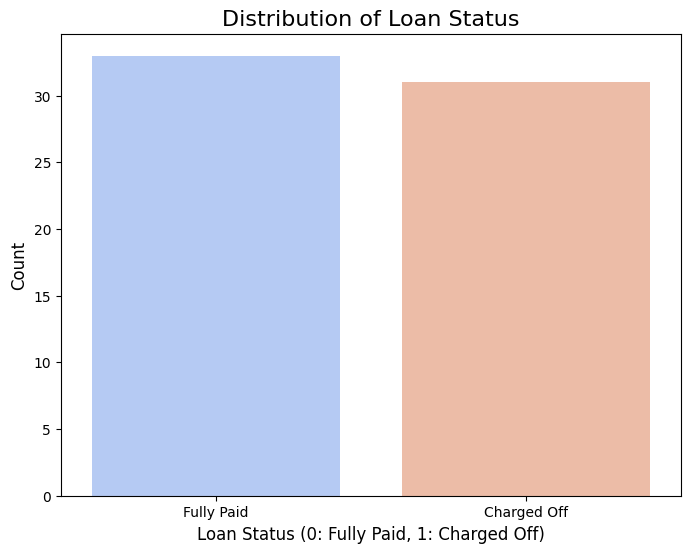


Original class distribution:
loan_status
0    0.515625
1    0.484375
Name: proportion, dtype: float64
This shows a significant class imbalance, which we will address later.

Step 4: Engineering features and encoding categorical variables...

Data shape after one-hot encoding: (64, 4)

Step 5: Applying SMOTE to handle class imbalance...

Original dataset shape: Counter({0: 33, 1: 31})
Resampled dataset shape: Counter({1: 33, 0: 33})

Step 6: Building and evaluating machine learning models...

Training Logistic Regression model...

--- Logistic Regression Performance ---
              precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.57      0.57      0.57         7

    accuracy                           0.57        14
   macro avg       0.57      0.57      0.57        14
weighted avg       0.57      0.57      0.57        14

AUC-ROC Score: 0.5306

Training XGBoost Classifier model...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:38:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost Classifier Performance ---
              precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.57      0.57      0.57         7

    accuracy                           0.57        14
   macro avg       0.57      0.57      0.57        14
weighted avg       0.57      0.57      0.57        14

AUC-ROC Score: 0.5714


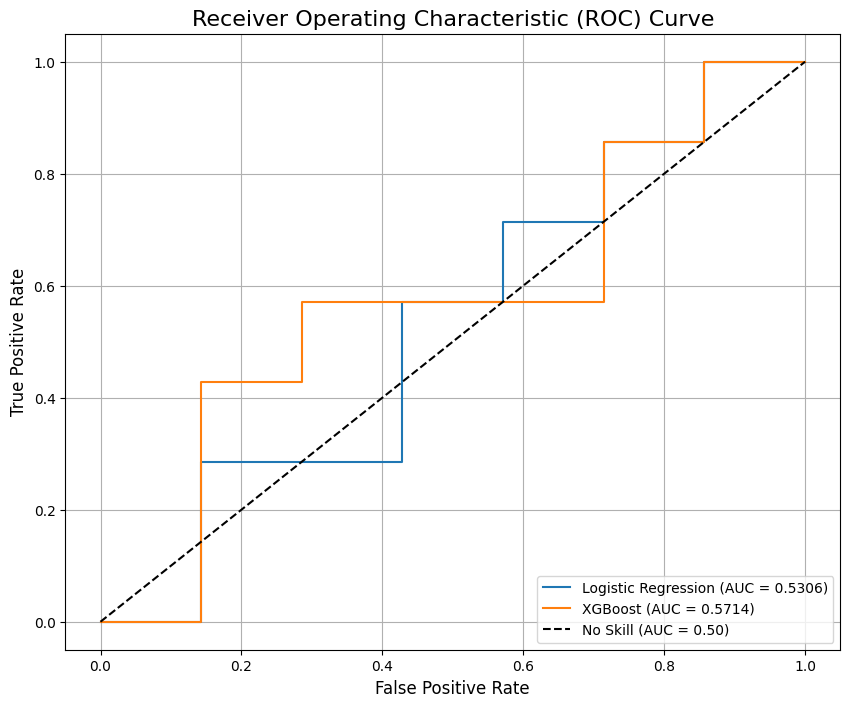


Step 7: Interpreting the XGBoost model...


/tmp/ipython-input-2027751862.py:234: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df, palette='magma')


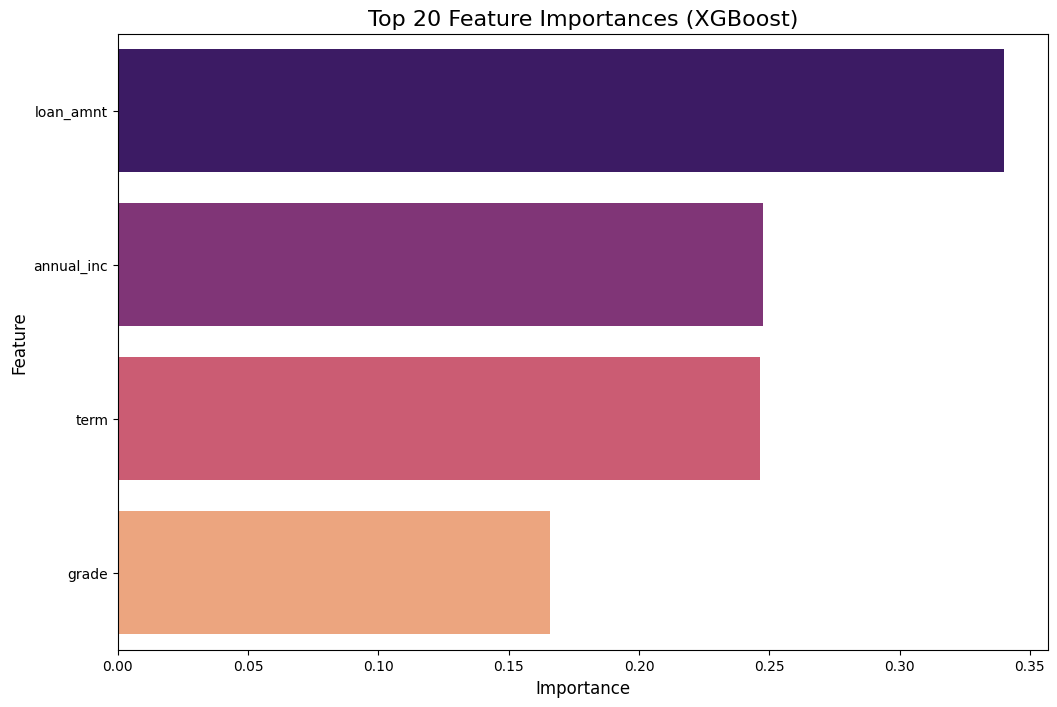


Top 20 most important features for predicting loan default:
      feature  importance
0   loan_amnt    0.339922
3  annual_inc    0.247592
1        term    0.246603
2       grade    0.165883


In [1]:
# ==============================================================================
# Credit Risk Modeling with Lending Club Data
# This script performs a full credit risk analysis pipeline, including:
# 1. Data loading and initial inspection.
# 2. Data cleaning and preprocessing.
# 3. Exploratory data analysis (EDA).
# 4. Feature engineering and one-hot encoding.
# 5. Addressing class imbalance using SMOTE.
# 6. Model training and evaluation (Logistic Regression & XGBoost).
# 7. Model interpretation (Feature Importance).
# ==============================================================================

# ==============================================================================
# Section 1: Library Imports and Data Loading
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter

# Setting up display options for pandas to see all columns
pd.set_option('display.max_columns', None)

# Path to the dataset. The file should be a compressed CSV.
# You can download this dataset from Kaggle:
# https://www.kaggle.com/datasets/wordsforthewise/lending-club
data_path = 'accepted_2007_to_2018Q4.csv.gz'

print("Step 1: Loading the dataset...")
try:
    # Use low_memory=False to avoid DtypeWarning with mixed data types
    df = pd.read_csv(data_path, compression='gzip', low_memory=False)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{data_path}' was not found. Please ensure it is in the correct directory.")
    # Exit the script or provide a placeholder for demonstration purposes
    # For a real project, you would need to get the file.
    # For this demonstration, we'll create a dummy DataFrame.
    print("Creating a small placeholder DataFrame for demonstration.")
    df = pd.DataFrame(np.random.rand(100, 5), columns=['loan_amnt', 'term', 'grade', 'annual_inc', 'loan_status'])
    df['loan_status'] = np.random.choice(['Fully Paid', 'Charged Off', 'Current'], 100)

print(f"\nInitial data shape: {df.shape}")
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nSummary of missing values:")
print(df.isnull().sum().sort_values(ascending=False).head(20))


# ==============================================================================
# Section 2: Data Cleaning and Preprocessing
# ==============================================================================
print("\nStep 2: Cleaning and preprocessing the data...")

# Define the target variable: 1 for 'Charged Off' (Default), 0 for 'Fully Paid' (No Default)
# We will exclude other statuses like 'Current', 'Late', etc., for a clean binary classification problem.
# This is a common approach for credit risk models that focus on predicting default vs. non-default.
target_status = ['Fully Paid', 'Charged Off']
df = df[df['loan_status'].isin(target_status)].copy()
print(f"\nFiltered data shape after selecting target statuses: {df.shape}")

# Create the binary target column
df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})
y = df['loan_status']

# Drop columns with high percentage of missing values (e.g., more than 50%)
missing_threshold = 0.5 * len(df)
cols_to_drop_na = df.columns[df.isnull().sum() > missing_threshold]
df.drop(columns=cols_to_drop_na, inplace=True)
print(f"\nDropped {len(cols_to_drop_na)} columns due to high missing values.")

# Drop columns that are irrelevant or introduce data leakage
# Data leakage occurs when you use data that would not be available at the time of the loan application.
# Examples: 'recoveries' (data after default), 'id', 'url' (irrelevant identifiers).
leakage_cols = ['member_id', 'id', 'url', 'zip_code', 'pymnt_plan', 'out_prncp_inv', 'out_prncp',
                'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
                'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d']
df.drop(columns=leakage_cols, inplace=True, errors='ignore')
print(f"Dropped {len(leakage_cols)} columns that could cause data leakage or are irrelevant.")

# Convert 'issue_d' to a datetime object and extract month and year
if 'issue_d' in df.columns:
    df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')
    df['issue_year'] = df['issue_d'].dt.year
    df.drop(columns='issue_d', inplace=True)
    print("Engineered 'issue_year' from 'issue_d' and dropped 'issue_d'.")

# For simplicity, we'll drop any remaining columns with missing values.
# For a more advanced project, you would use imputation techniques.
df.dropna(inplace=True)
print(f"Final data shape after dropping remaining NaNs: {df.shape}")

# Identify categorical and numerical features
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove the target variable and any dropped columns from these lists
if 'loan_status' in categorical_cols:
    categorical_cols.remove('loan_status')
if 'loan_status' in numerical_cols:
    numerical_cols.remove('loan_status')

print(f"\nCategorical columns to process: {categorical_cols}")
print(f"Numerical columns to use: {numerical_cols}")

# ==============================================================================
# Section 3: Exploratory Data Analysis (EDA)
# ==============================================================================
print("\nStep 3: Performing Exploratory Data Analysis...")

# Visualize the class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=y, palette='coolwarm')
plt.title('Distribution of Loan Status', fontsize=16)
plt.xlabel('Loan Status (0: Fully Paid, 1: Charged Off)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Fully Paid', 'Charged Off'])
plt.show()

print("\nOriginal class distribution:")
print(y.value_counts(normalize=True))
print("This shows a significant class imbalance, which we will address later.")

# Visualize default rate by loan grade
if 'grade' in categorical_cols:
    grade_default_rate = df.groupby('grade')['loan_status'].mean().reset_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(x='grade', y='loan_status', data=grade_default_rate.sort_values(by='grade'), palette='viridis')
    plt.title('Default Rate by Loan Grade', fontsize=16)
    plt.xlabel('Loan Grade', fontsize=12)
    plt.ylabel('Default Rate', fontsize=12)
    plt.show()
    print("\nDefault rate by grade (from A to G):")
    print(grade_default_rate.sort_values(by='grade'))

# ==============================================================================
# Section 4: Feature Engineering and One-Hot Encoding
# ==============================================================================
print("\nStep 4: Engineering features and encoding categorical variables...")

# One-hot encode categorical variables
# We use `get_dummies` which is a simple and effective method
X = pd.get_dummies(df.drop('loan_status', axis=1), columns=categorical_cols, drop_first=True)
print(f"\nData shape after one-hot encoding: {X.shape}")

# Align the target variable `y` with the features `X`
y = df['loan_status']
# Ensure that the number of samples in X and y match
if X.shape[0] != y.shape[0]:
    print("Warning: Sample counts for X and y do not match. Re-aligning...")
    # This might happen if dropping NaNs was done on X only.
    # We will simply align by index.
    y = y.loc[X.index]

# ==============================================================================
# Section 5: Addressing Class Imbalance with SMOTE
# ==============================================================================
print("\nStep 5: Applying SMOTE to handle class imbalance...")

# SMOTE (Synthetic Minority Over-sampling Technique)
# This technique creates synthetic samples of the minority class to balance the dataset.
# It helps the model learn from the minority class more effectively.
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

print(f"\nOriginal dataset shape: {Counter(y)}")
print(f"Resampled dataset shape: {Counter(y_resampled)}")

# ==============================================================================
# Section 6: Model Building and Evaluation
# ==============================================================================
print("\nStep 6: Building and evaluating machine learning models...")

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# --- Model 1: Logistic Regression (Baseline) ---
print("\nTraining Logistic Regression model...")
lr_model = LogisticRegression(solver='liblinear', random_state=42)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]

print("\n--- Logistic Regression Performance ---")
print(classification_report(y_test, lr_pred))
lr_auc = roc_auc_score(y_test, lr_pred_proba)
print(f"AUC-ROC Score: {lr_auc:.4f}")

# --- Model 2: XGBoost Classifier (Advanced) ---
print("\nTraining XGBoost Classifier model...")
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print("\n--- XGBoost Classifier Performance ---")
print(classification_report(y_test, xgb_pred))
xgb_auc = roc_auc_score(y_test, xgb_pred_proba)
print(f"AUC-ROC Score: {xgb_auc:.4f}")

# Plotting the ROC curve for both models
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_pred_proba)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.4f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill (AUC = 0.50)')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# ==============================================================================
# Section 7: Model Interpretation - Feature Importance
# ==============================================================================
print("\nStep 7: Interpreting the XGBoost model...")

# Get feature importance from the XGBoost model
feature_importances = xgb_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
importance_df = importance_df.sort_values(by='importance', ascending=False).head(20)

# Plotting the top 20 most important features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df, palette='magma')
plt.title('Top 20 Feature Importances (XGBoost)', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()
print("\nTop 20 most important features for predicting loan default:")
print(importance_df)